In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('Data/Month_value_1.csv')

df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
91,01.08.2022,NaN,NaN,NaN,NaN
92,01.09.2022,NaN,NaN,NaN,NaN
93,01.10.2022,NaN,NaN,NaN,NaN
94,01.11.2022,NaN,NaN,NaN,NaN


In [2]:
df.isnull().sum()

Period                                       0
Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64

In [3]:
df = df.dropna()

df.describe()

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
count,6.400000e+01,64.000000,64.000000,6.400000e+01
mean,3.236045e+07,19197.375000,1695.061159,2.869083e+07
std,1.164150e+07,6591.287257,296.844793,1.057191e+06
min,1.402148e+07,8314.000000,1110.576805,2.740647e+07
25%,2.242655e+07,15065.500000,1499.142841,2.782857e+07
50%,3.209088e+07,18368.000000,1654.399798,2.819785e+07
75%,3.992999e+07,22856.250000,1916.401096,2.987852e+07
max,5.875647e+07,38069.000000,2559.328184,3.002468e+07


In [4]:
import seaborn as sns
df['Period'] = pd.to_datetime(df['Period'])
df = df.sort_values(by= 'Period')


C:\Users\ducth\AppData\Local\Temp\ipykernel_24052\1651473612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Period'] = pd.to_datetime(df['Period'])


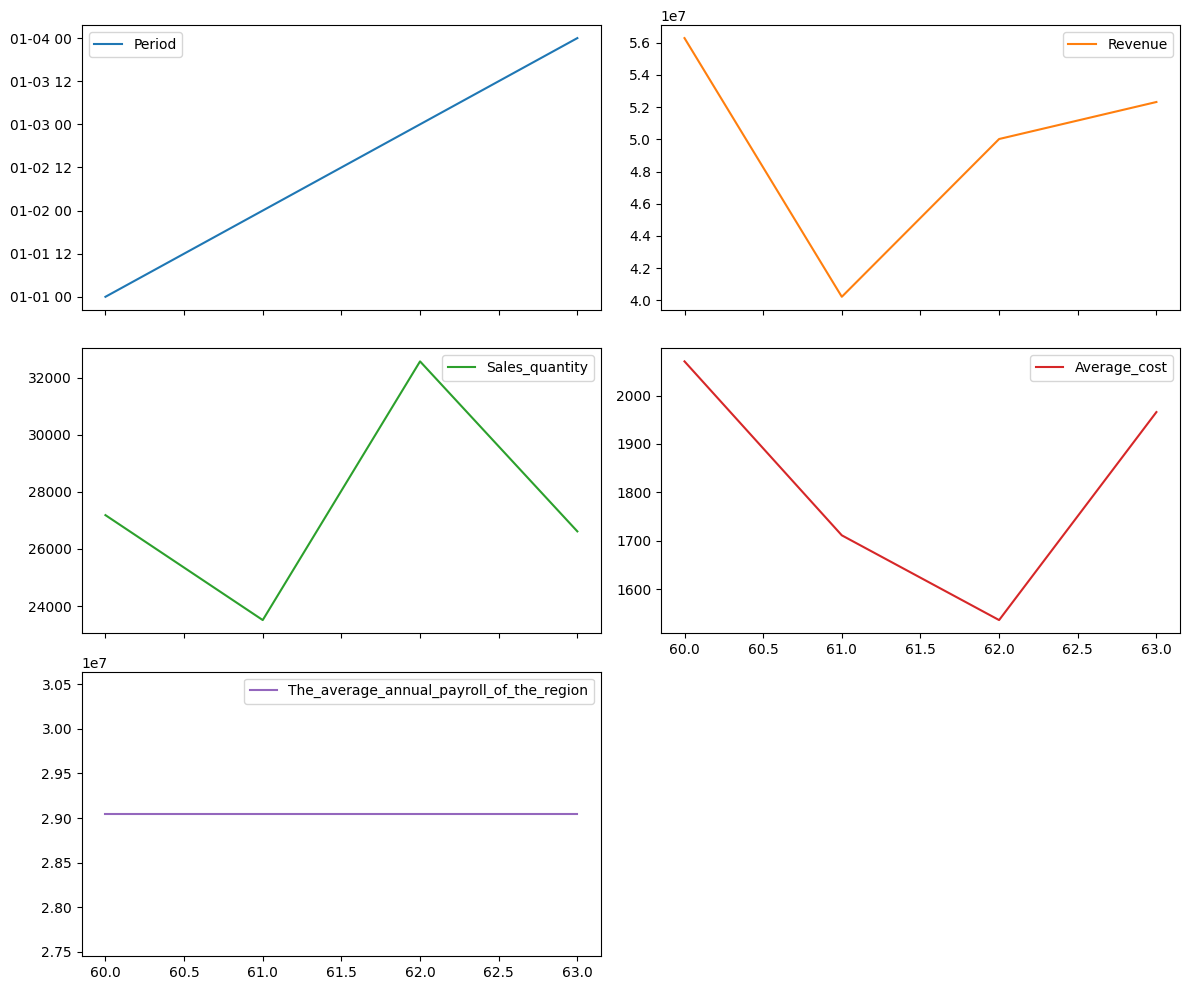

In [5]:
cutoff = df['Period'].max() - pd.Timedelta(days = 90)

cutoff_df = df[df['Period'] >= cutoff]

cutoff_df.plot(subplots=True, figsize=(12, 10), layout=(-1, 2), sharex=True)

plt.tight_layout()
plt.show()

In [6]:
df.columns

Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

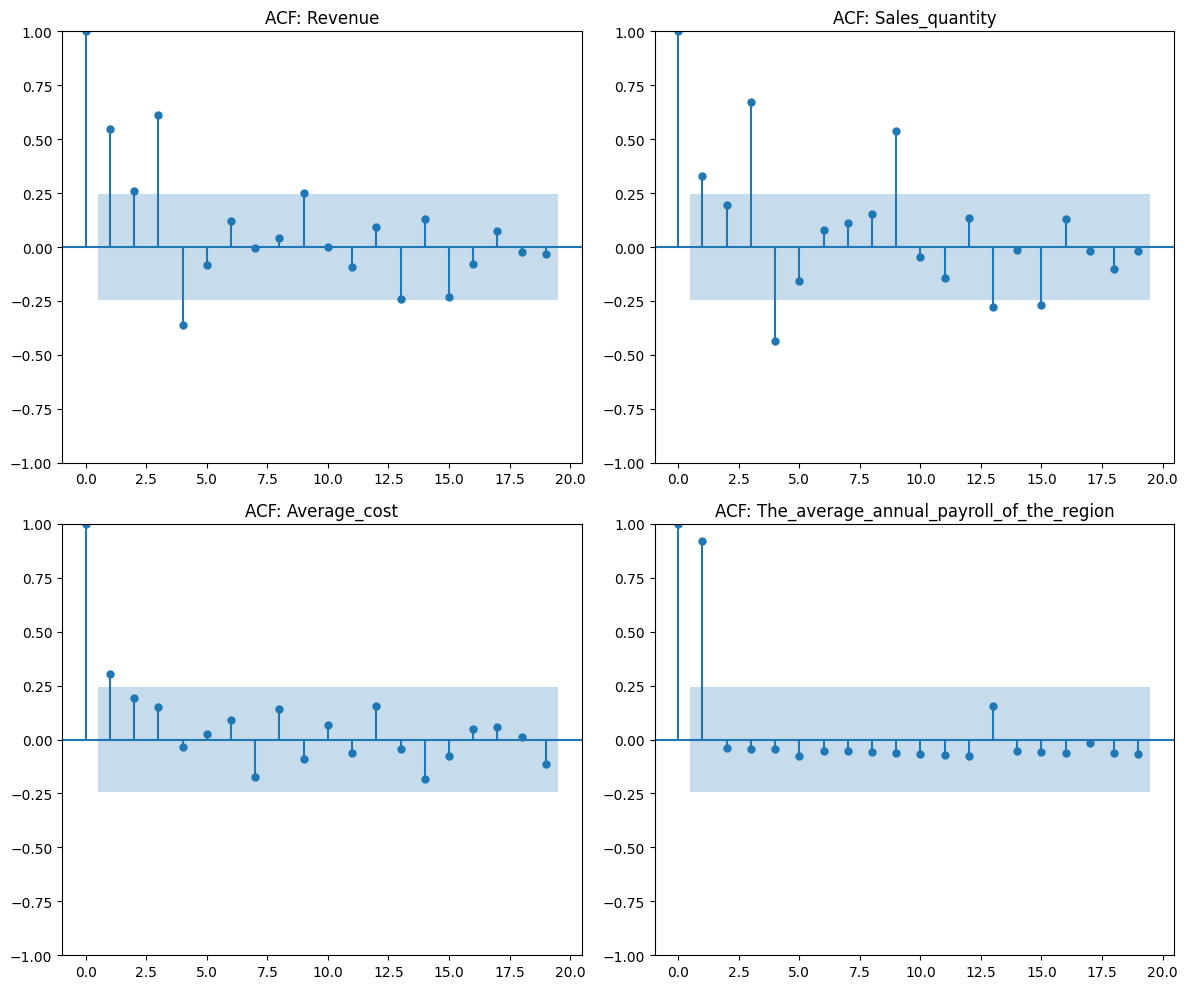

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

features = ['Revenue', 'Sales_quantity', 'Average_cost', 
            'The_average_annual_payroll_of_the_region']


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))


axes = axes.flatten()


for i, col in enumerate(features):
    plot_pacf(df[col], ax=axes[i])
    axes[i].set_title(f"ACF: {col}")


plt.tight_layout()
plt.show()

In [8]:
df['Day of Week'] = df['Period'].dt.dayofweek
df['is_weekend'] = df['Day of Week'].isin([5,6]).astype(int)

df['day_sin'] = np.sin(2 * np.pi * df['Day of Week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['Day of Week'] / 7)

df['Revenue_lag1'] = df['Revenue'].shift(1)
df['Revenue_lag3'] = df['Revenue'].shift(3)
df['Sales_quantity_lag1'] = df['Sales_quantity'].shift(1)
df['Sales_quantity_lag3'] = df['Sales_quantity'].shift(3)
df['payroll_lag1'] = df['The_average_annual_payroll_of_the_region'].shift(1)
df['Average_cost_lag1'] = df['Average_cost'].shift(1)
df = df.dropna()
df.isnull().sum()


Period                                      0
Revenue                                     0
Sales_quantity                              0
Average_cost                                0
The_average_annual_payroll_of_the_region    0
Day of Week                                 0
is_weekend                                  0
day_sin                                     0
day_cos                                     0
Revenue_lag1                                0
Revenue_lag3                                0
Sales_quantity_lag1                         0
Sales_quantity_lag3                         0
payroll_lag1                                0
Average_cost_lag1                           0
dtype: int64

In [10]:
y = df['Revenue']

X = df[['is_weekend', 'day_sin', 'day_cos',
    'Sales_quantity_lag1', 'Sales_quantity_lag3', 'Average_cost_lag1', 
        'Revenue_lag3', 'payroll_lag1', 'Revenue_lag1', 'Revenue_lag3']]



split = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


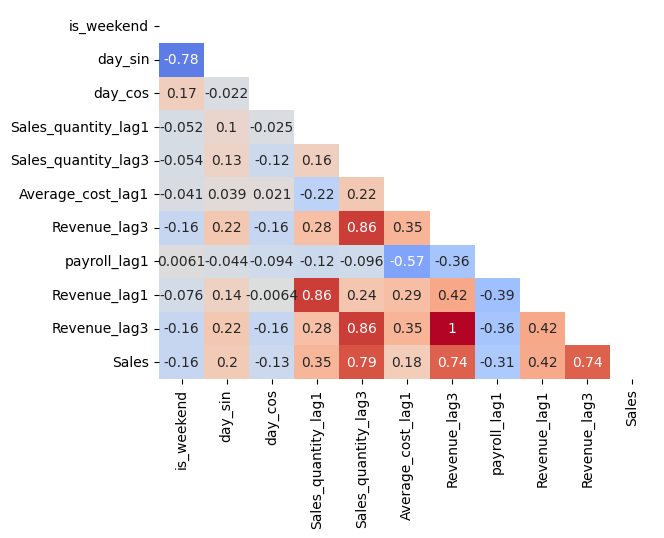

In [11]:
corr_df = X_train.copy()
corr_df['Sales'] = y_train

matrix = corr_df.corr()

mask = np.triu(np.ones_like(matrix, dtype = bool))
sns.heatmap(matrix, mask= mask, center = 0, cmap = 'coolwarm',
            annot = True, cbar = False)

plt.show()


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

base = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state = 8))
])


base.fit(X_train, y_train)
xgb.fit(X_train, y_train)

,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None


In [13]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

y_base = base.predict(X_test)
y_xgb = xgb.predict(X_test)

print("Base model:")
print(f"MAE %: {mean_absolute_percentage_error(y_true= y_test, y_pred= y_base):.4f}")
print(f"R2: {r2_score(y_true= y_test, y_pred= y_base):.4f}")

print("==============================================")
print("XGB model:")
print(f"MAE %: {mean_absolute_percentage_error(y_true= y_test, y_pred= y_xgb):.4f}")
print(f"R2: {r2_score(y_true= y_test, y_pred= y_xgb):.4f}")

Base model:
MAE %: 0.2446
R2: -1.5917
XGB model:
MAE %: 0.2064
R2: -0.9335


In [14]:
df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region,Day of Week,is_weekend,day_sin,day_cos,Revenue_lag1,Revenue_lag3,Sales_quantity_lag1,Sales_quantity_lag3,payroll_lag1,Average_cost_lag1
3,2015-01-04,1.881458e+07,15227.0,1235.606705,30024676.0,6,1,-0.781831,0.623490,2.204715e+07,1.601007e+07,15922.0,12729.0,30024676.0,1384.697024
4,2015-01-05,1.402148e+07,8620.0,1626.621765,30024676.0,0,0,0.000000,1.000000,1.881458e+07,1.580759e+07,15227.0,11636.0,30024676.0,1235.606705
5,2015-01-06,1.678393e+07,13160.0,1275.374508,30024676.0,1,0,0.781831,0.623490,1.402148e+07,2.204715e+07,8620.0,15922.0,30024676.0,1626.621765
6,2015-01-07,1.916189e+07,17254.0,1110.576805,30024676.0,2,0,0.974928,-0.222521,1.678393e+07,1.881458e+07,13160.0,15227.0,30024676.0,1275.374508
7,2015-01-08,1.520498e+07,8642.0,1759.428870,30024676.0,3,0,0.433884,-0.900969,1.916189e+07,1.402148e+07,17254.0,8620.0,30024676.0,1110.576805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-01-12,5.875647e+07,38069.0,1543.420464,29878525.0,5,1,-0.974928,-0.222521,3.637496e+07,4.852626e+07,21987.0,23253.0,29878525.0,1654.384704
60,2020-01-01,5.628830e+07,27184.0,2070.640850,29044998.0,2,0,0.974928,-0.222521,5.875647e+07,4.416042e+07,38069.0,26603.0,29878525.0,1543.420464
61,2020-01-02,4.022524e+07,23509.0,1711.057181,29044998.0,3,0,0.433884,-0.900969,5.628830e+07,3.637496e+07,27184.0,21987.0,29044998.0,2070.640850
62,2020-01-03,5.002217e+07,32569.0,1535.882748,29044998.0,4,0,-0.433884,-0.900969,4.022524e+07,5.875647e+07,23509.0,38069.0,29044998.0,1711.057181
